In [1]:
import argparse
import os
import struct
import time
from pathlib import Path
from typing import List, Optional, Callable, Sequence

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# For visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
class VDBLeafDataset(Dataset):
    def __init__(
            self,
            npy_files: Sequence[str | Path],
            transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
            *,
            include_origins: bool = False,
            origins_root: str | Path | None = None,
            origins_suffix: str = "._origins.npy",
    ) -> None:
        super().__init__()

        self.transform = transform
        self.include_origins = include_origins

        # --- mmap all data files -------------------------------------------------
        self.arrays: List[np.memmap] = []
        self.origin_arrays: List[np.memmap] | None = [] if include_origins else None

        for f in npy_files:
            arr = np.load(f, mmap_mode="r")
            if arr.shape[1:] != (8, 8, 8):
                raise ValueError(f"{f}: expected (N, 8, 8, 8), got {arr.shape}")
            self.arrays.append(arr)

            if include_origins:
                if origins_root is not None:
                    origin_path = Path(origins_root) / (Path(f).stem + origins_suffix)
                else:
                    origin_path = Path(f).with_suffix(origins_suffix)
                if not origin_path.exists():
                    raise FileNotFoundError(origin_path)

                self.origin_arrays.append(np.load(origin_path, mmap_mode="r"))

        # --- pre-compute global index mapping ------------------------------------
        lengths = np.fromiter((a.shape[0] for a in self.arrays), dtype=np.int64)
        self.file_offsets = np.concatenate(([0], np.cumsum(lengths)))
        self.total_leaves: int = int(self.file_offsets[-1])

    # ---------------------------------------------------------------------------

    def __len__(self) -> int:
        return self.total_leaves

    def __getitem__(self, idx: int):
        if not (0 <= idx < self.total_leaves):
            raise IndexError(idx)

        # locate (file, local) in O(log n) inside highly-optimised C code
        file_idx = int(np.searchsorted(self.file_offsets, idx, side="right") - 1)
        local_idx = idx - int(self.file_offsets[file_idx])

        # zero-copy view from the mmap’d array
        leaf_np = self.arrays[file_idx][local_idx].astype(np.float32, copy=True)
        leaf = torch.from_numpy(leaf_np).to(torch.float32).unsqueeze(0)

        if self.transform is not None:
            leaf = self.transform(leaf)

        if self.include_origins:
            origin_np = self.origin_arrays[file_idx][local_idx].astype(np.int32, copy=False)
            origin = torch.from_numpy(origin_np)
            return leaf, origin

        return leaf


In [3]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int,
                 commitment_cost: float, decay: float = 0.99, eps: float = 1e-5):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.eps = eps

        # Initialize embeddings
        embed = torch.randn(num_embeddings, embedding_dim) * 0.1  # Small variance
        embed = F.normalize(embed, dim=1)  # Normalize initial embeddings
        
        self.register_buffer('embedding', embed)
        self.register_buffer('cluster_size', torch.ones(num_embeddings))
        self.register_buffer('embed_avg', embed.clone().detach())

    def forward(self, x):
        B, D, *spatial = x.shape
        flat = x.permute(0, *range(2, 2+len(spatial)), 1).contiguous().view(-1, D)

        # Compute distances
        distances = torch.cdist(flat, self.embedding, p=2)  # More stable than manual computation


        # Get nearest codes
        encoding_indices = torch.argmin(distances, dim=1)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).type(flat.dtype)

        # Quantize
        quantized = encodings @ self.embedding
        quantized = quantized.view(B, *spatial, D).permute(0, -1, *range(1, 1+len(spatial)))

        # EMA updates (simplified)
        if self.training:
            with torch.no_grad():
                encodings_sum = encodings.sum(0)
                self.cluster_size.mul_(self.decay).add_(encodings_sum, alpha=1-self.decay)
                
                dw = encodings.t() @ flat.detach()
                self.embed_avg.mul_(self.decay).add_(dw, alpha=1-self.decay)
                
                # Normalize with better numerical stability
                n = self.cluster_size.clamp(min=self.eps)
                self.embedding.copy_(self.embed_avg / n.unsqueeze(1))


        commitment_loss = self.commitment_cost * F.mse_loss(x, quantized.detach())
        loss = commitment_loss

        # Straight-through estimator
        quantized = x + (quantized - x).detach()

        # Perplexity
        avg_probs = encodings.mean(0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, loss, perplexity


# --- Encoder ---
class Encoder(nn.Module):
    def __init__(self, in_channels, embedding_dim):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            # 8³ → 4³
            nn.Conv3d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            
            # Refine at 4³
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            
            # Final projection
            nn.Conv3d(64, embedding_dim, kernel_size=3, stride=1, padding=1),
        )
    def forward(self, x):
        return self.net(x)

# --- Decoder ---
class Decoder(nn.Module):
    def __init__(self, embedding_dim, out_channels):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            # Expand from embedding_dim
            nn.Conv3d(embedding_dim, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            
            # 4³ → 8³
            nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            
            # Final reconstruction
            nn.Conv3d(32, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.net(x)

# --- Full VQ-VAE Model ---
class VQVAE(nn.Module):
    def __init__(self, in_channels, embedding_dim, num_embeddings, commitment_cost):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(in_channels, embedding_dim)
        self.quantizer = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost=0.25)
        self.decoder = Decoder(embedding_dim, in_channels)

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, perplexity = self.quantizer(z)
        x_recon = self.decoder(quantized)
        return x_recon, vq_loss, perplexity

    def encode(self, x):
        z = self.encoder(x)
        flat_z = z.permute(0, *range(2, z.ndim), 1).contiguous().view(-1, self.quantizer.embedding_dim)
        distances = (torch.sum(flat_z**2, dim=1, keepdim=True) 
                     + torch.sum(self.quantizer.embedding**2, dim=1)
                     - 2 * torch.matmul(flat_z, self.quantizer.embedding.t()))
        indices = torch.argmin(distances, dim=1)
        return indices.view(z.shape[0], *z.shape[2:])

    def decode(self, indices):
        quantized_vectors = F.embedding(indices, self.quantizer.embedding)
        quantized_for_decoder = quantized_vectors.permute(0, quantized_vectors.ndim - 1, *range(1, quantized_vectors.ndim - 1))
        x_recon = self.decoder(quantized_for_decoder)
        return x_recon
        

In [4]:
# Hyperparameters
BATCH_SIZE = 8192
EPOCHS = 50
LR = 5e-4
IN_CHANNELS = 1
EMBEDDING_DIM = 128 # The dimensionality of the embeddings
NUM_EMBEDDINGS = 256 # The size of the codebook (the "dictionary")
COMMITMENT_COST = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

npy_files = list(Path("data/npy").glob("*.npy"))
if not npy_files:
    raise ValueError(f"No .npy files found in /data/npy")

print(f"Found {len(npy_files)} .npy files")

vdb_dataset = VDBLeafDataset(npy_files=npy_files, include_origins=False)
print(f"Dataset created with {len(vdb_dataset)} total blocks.")

# keep 10% of the dataset for validation
split_idx = int(len(vdb_dataset) * 0.3)
vdb_dataset_train = torch.utils.data.Subset(vdb_dataset, range(split_idx))
vdb_dataset_val = torch.utils.data.Subset(vdb_dataset, range(split_idx, len(vdb_dataset)))
print(f"Training dataset size: {len(vdb_dataset_train)}")
print(f"Validation dataset size: {len(vdb_dataset_val)}")


train_loader = DataLoader(
    vdb_dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True,
)


Using device: cuda
Found 120 .npy files
Dataset created with 721739 total blocks.
Training dataset size: 216521
Validation dataset size: 505218


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = VQVAE(IN_CHANNELS, EMBEDDING_DIM, NUM_EMBEDDINGS, COMMITMENT_COST).to(device)
optimizer = Adam(model.parameters(), lr=LR)

Using device: cuda


In [ ]:

print("Starting training with data from DataLoader...")
for epoch in range(EPOCHS):
    
    total_recon_loss = 0.0
    total_vq_loss = 0
    
    for i, data_batch in enumerate(train_loader):
        leaves = data_batch.to(device, non_blocking=True)
        
        x_recon, vq_loss, perplexity = model(leaves)
        recon_error = F.mse_loss(x_recon, leaves)
        loss = recon_error + vq_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_recon_loss += recon_error.item()
        total_vq_loss += vq_loss.item()

    # Log progress at the end of each epoch
    avg_recon_loss = total_recon_loss / len(train_loader)
    avg_vq_loss = total_vq_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
            f"Avg Recon Loss: {avg_recon_loss:.5f} | "
            f"Avg VQ Loss: {avg_vq_loss:.5f} | "
            f"Last Perplexity: {perplexity.item():.4f}") # Perplexity from last batch

print("Training finished.")

Visualizing Reconstruction Quality for a Single Example


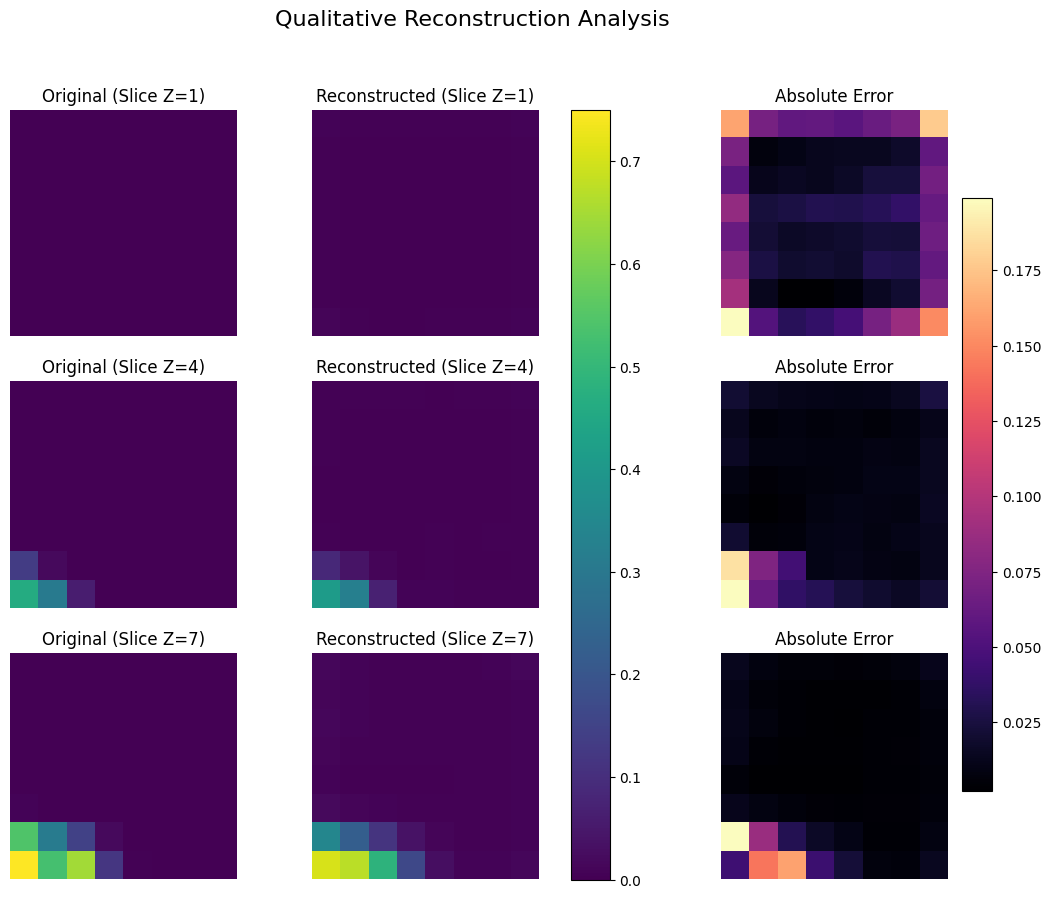

In [6]:
print("Visualizing Reconstruction Quality for a Single Example")
model.eval()

# Save the model state_dict
model_path = "C:/Users/zphrfx/Desktop/hdk/VQVDB/models/vqvae.pth"

# Visualize the reconstruction quality for a single example
model.load_state_dict(torch.load(model_path, map_location=device))


# Get a random block from the dataset
original_block = vdb_dataset[76343].unsqueeze(0).to(device)

# Perform the full compression/decompression cycle
indices = model.encode(original_block)
reconstructed_block = model.decode(indices)

# Detach from GPU and convert to numpy for plotting
original_np = original_block.squeeze().cpu().numpy()
reconstructed_np = reconstructed_block.squeeze().detach().cpu().numpy()
error_np = np.abs(original_np - reconstructed_np)

# Get consistent color limits for fair comparison
vmin = min(original_np.min(), reconstructed_np.min())
vmax = max(original_np.max(), reconstructed_np.max())

# --- Plot 1: Slice-by-Slice Comparison ---
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
slices_to_show = [1, 4, 7] # Show slices from the Z-axis of the 8x8x8 cube

for i, slice_idx in enumerate(slices_to_show):
    # Original
    im1 = axes[i, 0].imshow(original_np[slice_idx, :, :], vmin=vmin, vmax=vmax, cmap='viridis')
    axes[i, 0].set_title(f'Original (Slice Z={slice_idx})')
    axes[i, 0].axis('off')

    # Reconstructed
    im2 = axes[i, 1].imshow(reconstructed_np[slice_idx, :, :], vmin=vmin, vmax=vmax, cmap='viridis')
    axes[i, 1].set_title(f'Reconstructed (Slice Z={slice_idx})')
    axes[i, 1].axis('off')
    
    # Error Map
    im3 = axes[i, 2].imshow(error_np[slice_idx, :, :], cmap='magma')
    axes[i, 2].set_title('Absolute Error')
    axes[i, 2].axis('off')

fig.colorbar(im1, ax=axes[:,:2], orientation='vertical', fraction=.1)
fig.colorbar(im3, ax=axes[:,2], orientation='vertical', fraction=.1)
plt.suptitle('Qualitative Reconstruction Analysis', fontsize=16)
plt.show()

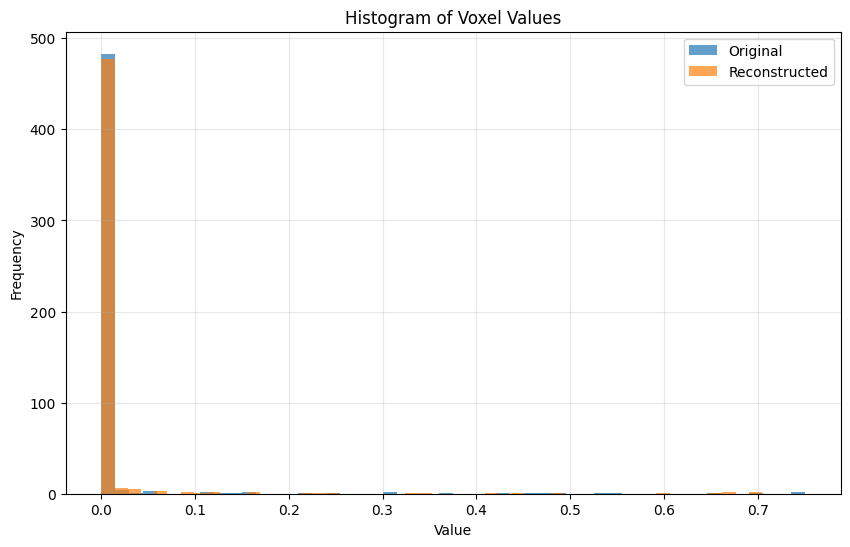

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(original_np.flatten(), bins=50, alpha=0.7, label='Original')
plt.hist(reconstructed_np.flatten(), bins=50, alpha=0.7, label='Reconstructed')
plt.title('Histogram of Voxel Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

PCA of the learned codebook vectors:


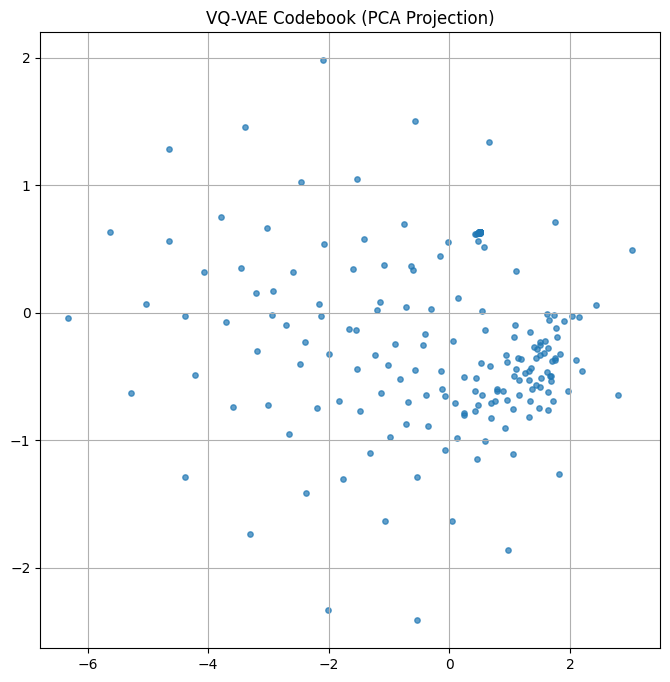


Calculating codebook usage across the entire dataset...


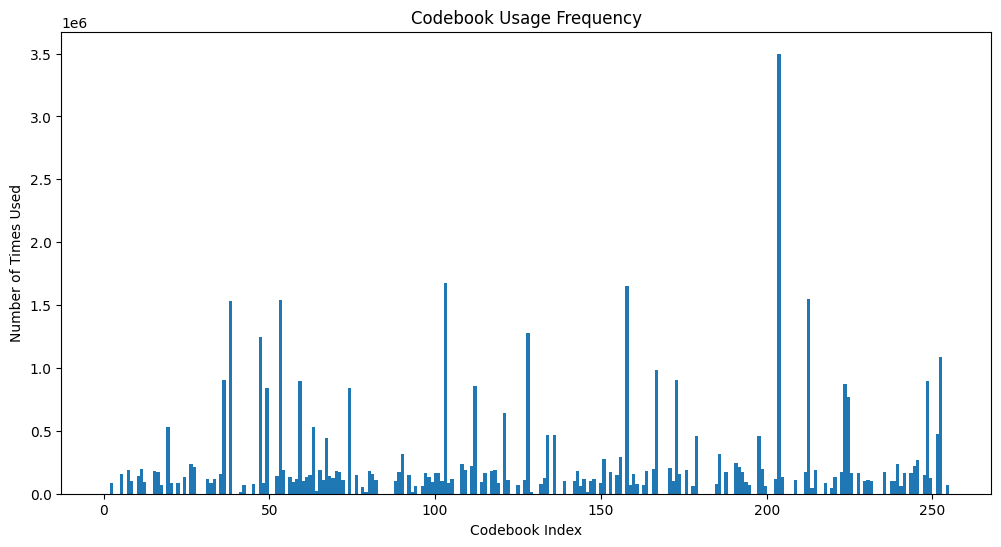

Number of 'dead' (unused) codes: 93 out of 256


In [8]:
print("PCA of the learned codebook vectors:")
codebook = model.quantizer.embedding.data.cpu()
pca = PCA(n_components=2)
codebook_2d = pca.fit_transform(codebook)
plt.figure(figsize=(8, 8))
plt.scatter(codebook_2d[:, 0], codebook_2d[:, 1], s=15, alpha=0.7)
plt.title('VQ-VAE Codebook (PCA Projection)')
plt.grid(True)
plt.show()

# --- Plot 2: Codebook Usage Histogram ---
# This is a powerful diagnostic. It requires running the encoder on the whole dataset.
print("\nCalculating codebook usage across the entire dataset...")
model.eval()
all_indices = []
# Create a dataloader without shuffling to iterate through the dataset
full_loader = DataLoader(vdb_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    for data_batch in full_loader:
        data_batch = data_batch.to(device) # Move data to the same device as the model
        indices = model.encode(data_batch)
        all_indices.append(indices.cpu().numpy().flatten())

all_indices = np.concatenate(all_indices)

plt.figure(figsize=(12, 6))
plt.hist(all_indices, bins=NUM_EMBEDDINGS, range=(0, NUM_EMBEDDINGS-1))
plt.title('Codebook Usage Frequency')
plt.xlabel('Codebook Index')
plt.ylabel('Number of Times Used')
plt.show()

num_dead_codes = NUM_EMBEDDINGS - len(np.unique(all_indices))
print(f"Number of 'dead' (unused) codes: {num_dead_codes} out of {NUM_EMBEDDINGS}")

--- Starting Comprehensive VQ-VAE Analysis ---
Processing 505218 samples from the dataset...
Data processing complete.

--- Quantitative Metrics ---
Overall Mean Squared Error (MSE) on dataset: 0.00064828


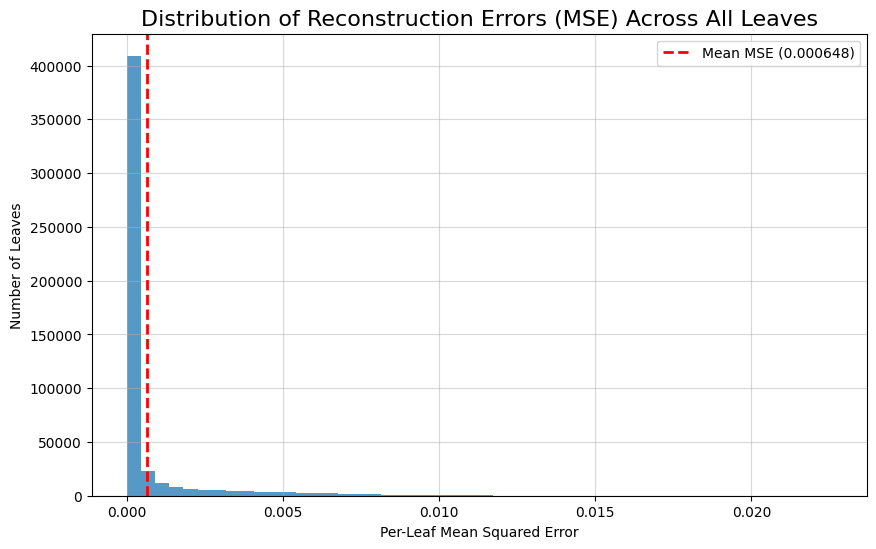


--- Latent Space & Codebook Analysis ---


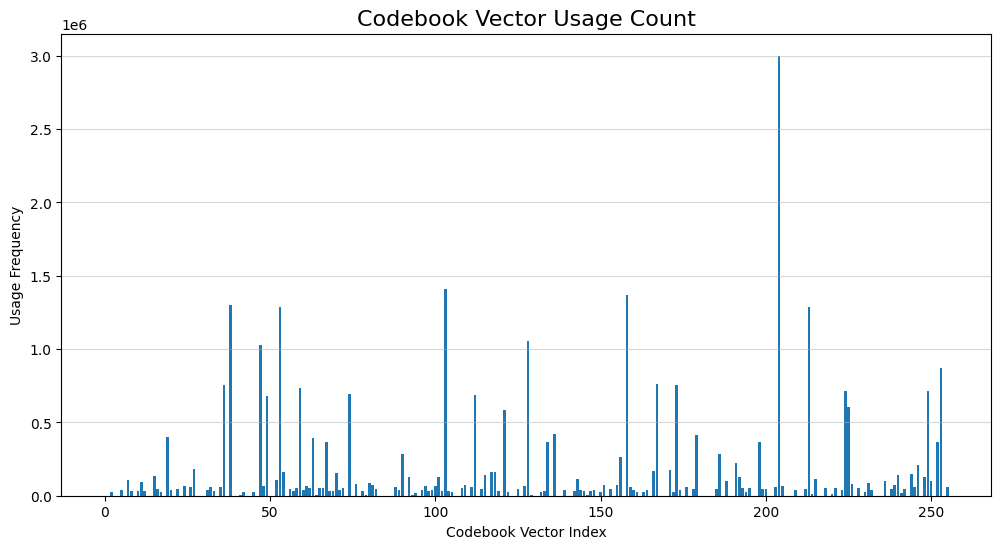

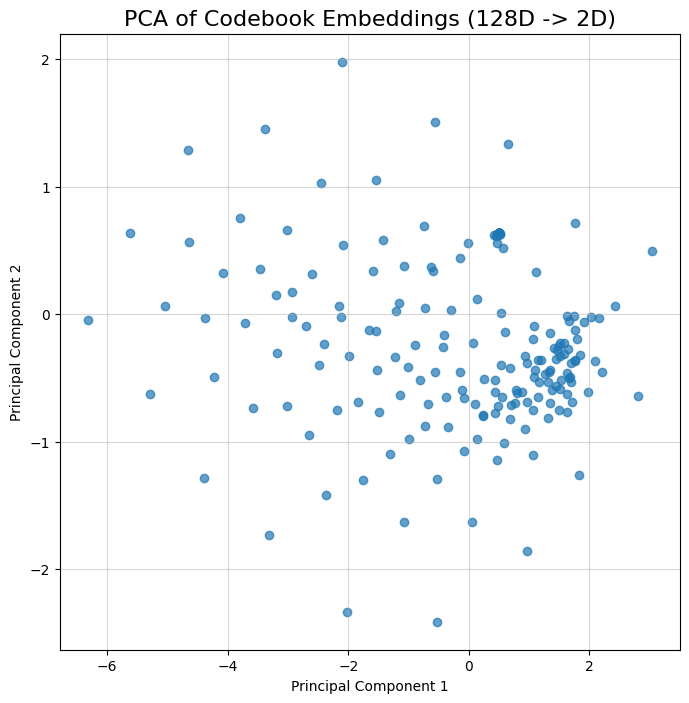


--- Qualitative Reconstruction Examples ---

--- 3 BEST Reconstructions (Lowest MSE) ---


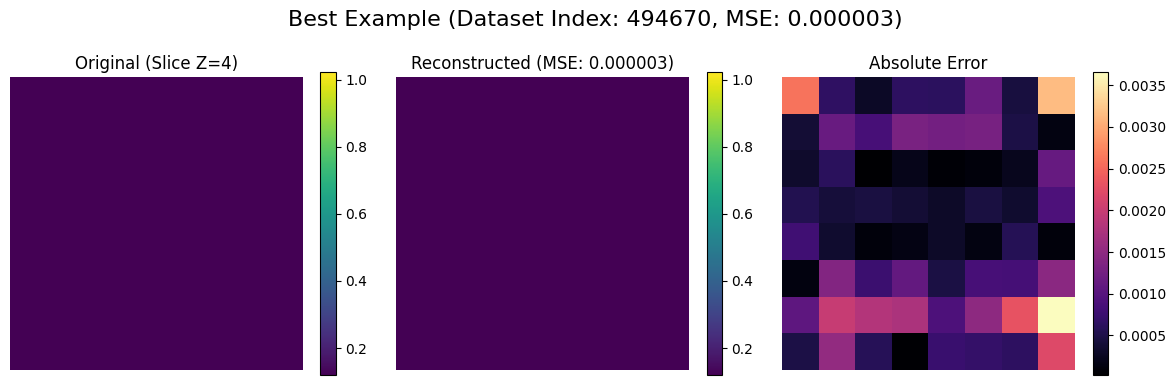

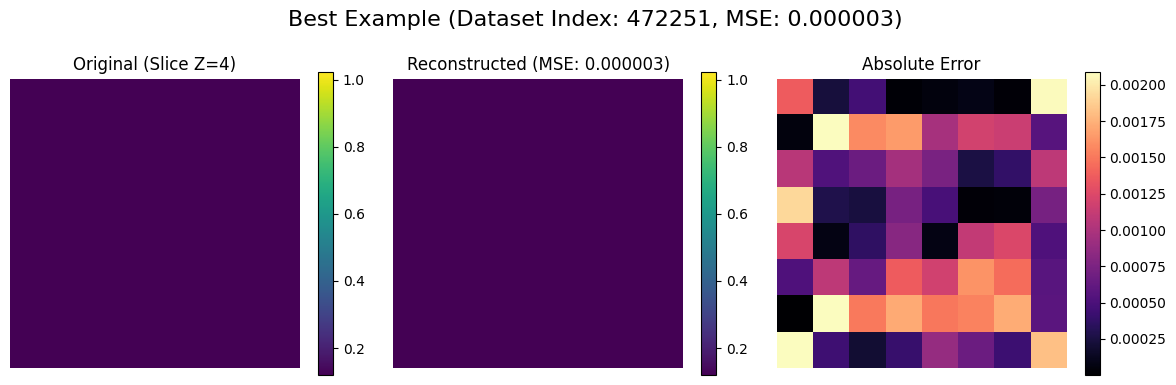

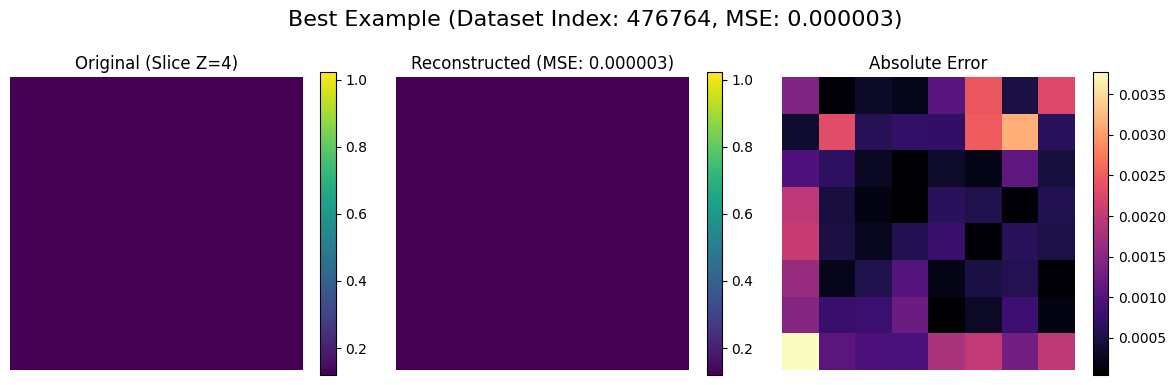


--- 3 WORST Reconstructions (Highest MSE) ---


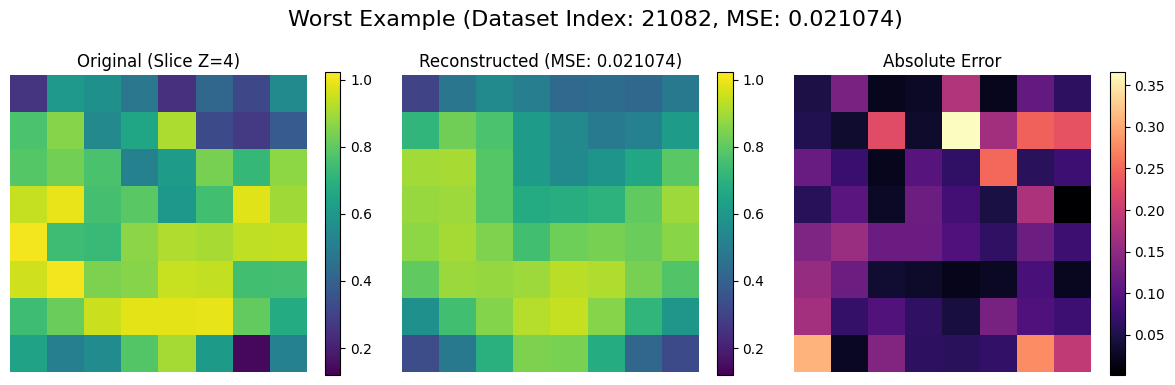

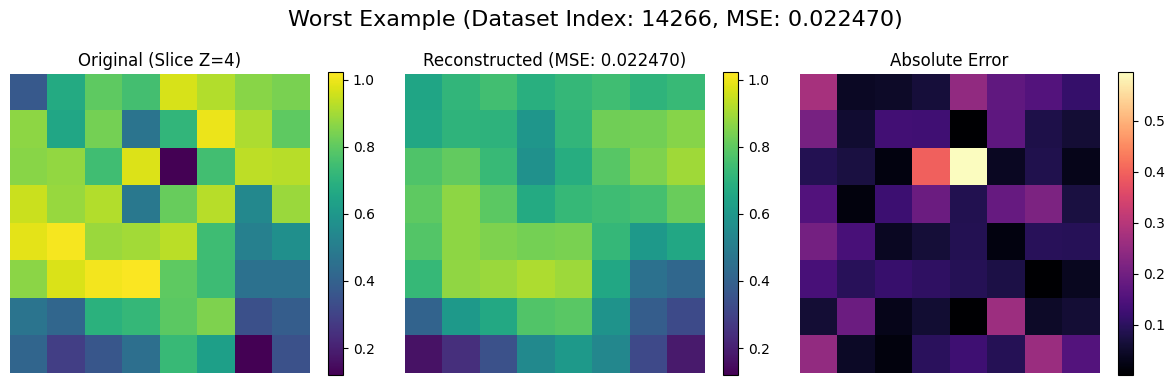

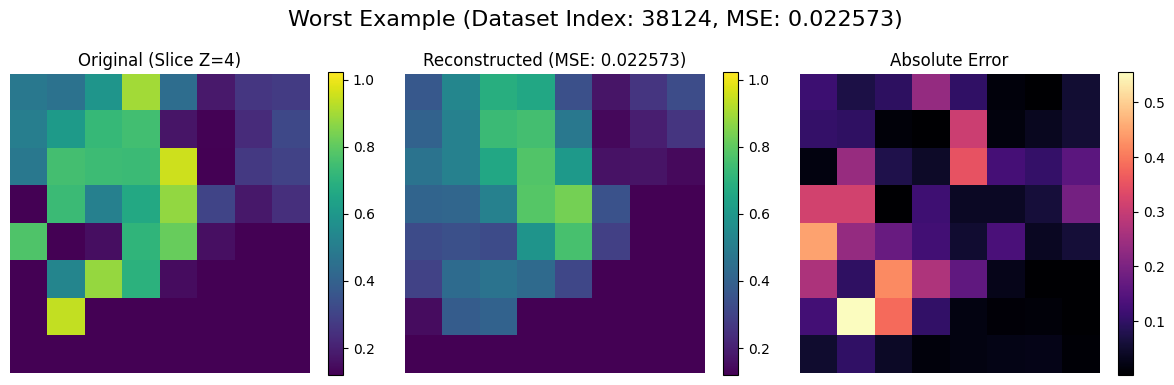

In [9]:
# --- Helper Function for Plotting ---
def plot_reconstruction_triplet(original_np, reconstructed_np, title_prefix, vmin, vmax):
    """Plots a single original/reconstructed/error triplet."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(title_prefix, fontsize=16)
    
    # Calculate error for this specific example
    error_np = np.abs(original_np - reconstructed_np)
    avg_mse = np.mean((original_np - reconstructed_np)**2)

    # Pick a middle slice to display
    slice_idx = original_np.shape[0] // 2

    # Original Slice
    im1 = axes[0].imshow(original_np[slice_idx, :, :], vmin=vmin, vmax=vmax, cmap='viridis')
    axes[0].set_title(f'Original (Slice Z={slice_idx})')
    axes[0].axis('off')
    fig.colorbar(im1, ax=axes[0])

    # Reconstructed Slice
    im2 = axes[1].imshow(reconstructed_np[slice_idx, :, :], vmin=vmin, vmax=vmax, cmap='viridis')
    axes[1].set_title(f'Reconstructed (MSE: {avg_mse:.6f})')
    axes[1].axis('off')
    fig.colorbar(im2, ax=axes[1])
    
    # Error Map
    im3 = axes[2].imshow(error_np[slice_idx, :, :], cmap='magma')
    axes[2].set_title('Absolute Error')
    axes[2].axis('off')
    fig.colorbar(im3, ax=axes[2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- Main Analysis Function ---
def run_comprehensive_analysis(model, dataset, device, num_embeddings, batch_size=512, num_examples_to_show=3):
    """
    Performs a full analysis of the VQ-VAE model and generates visualizations.
    """
    print("--- Starting Comprehensive VQ-VAE Analysis ---")
    model.eval()
    
    # Use a dataloader for efficient processing of the validation set
    val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    all_recon_errors = []
    all_indices = []
    
    # --- 1. GATHER DATA FROM THE ENTIRE VALIDATION SET ---
    print(f"Processing {len(dataset)} samples from the dataset...")
    with torch.no_grad():
        for batch_data in val_loader:
            leaves = batch_data.to(device)
            
            # Get reconstructions and latent indices
            x_recon, vq_loss, perplexity = model(leaves)
            indices = model.encode(leaves)
            
            # Calculate per-sample reconstruction error (MSE)
            # reduction='none' is key here
            recon_error_per_sample = F.mse_loss(x_recon, leaves, reduction='none')
            # Average over all dimensions except the batch dimension
            mse_per_sample = torch.mean(recon_error_per_sample, dim=(1, 2, 3, 4))
            
            all_recon_errors.append(mse_per_sample.cpu())
            all_indices.append(indices.cpu().view(-1)) # Flatten indices for histogram

    all_recon_errors = torch.cat(all_recon_errors)
    all_indices = torch.cat(all_indices)
    print("Data processing complete.")

    # --- 2. QUANTITATIVE ANALYSIS ---
    print("\n--- Quantitative Metrics ---")
    overall_mean_mse = all_recon_errors.mean().item()
    print(f"Overall Mean Squared Error (MSE) on dataset: {overall_mean_mse:.8f}")

    # Plot Histogram of Reconstruction Errors
    plt.figure(figsize=(10, 6))
    plt.hist(all_recon_errors.numpy(), bins=50, alpha=0.75)
    plt.axvline(overall_mean_mse, color='r', linestyle='--', linewidth=2, label=f'Mean MSE ({overall_mean_mse:.6f})')
    plt.title('Distribution of Reconstruction Errors (MSE) Across All Leaves', fontsize=16)
    plt.xlabel('Per-Leaf Mean Squared Error')
    plt.ylabel('Number of Leaves')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

    # --- 3. LATENT SPACE ANALYSIS ---
    print("\n--- Latent Space & Codebook Analysis ---")
    
    # Plot Codebook Usage
    usage_counts = torch.bincount(all_indices, minlength=num_embeddings)
    plt.figure(figsize=(12, 6))
    plt.bar(range(num_embeddings), usage_counts.numpy())
    plt.title('Codebook Vector Usage Count', fontsize=16)
    plt.xlabel('Codebook Vector Index')
    plt.ylabel('Usage Frequency')
    plt.grid(True, axis='y', alpha=0.5)
    plt.show()
    
    # PCA of Codebook Embeddings
    codebook_vectors = model.quantizer.embedding.data.cpu().numpy()
    if codebook_vectors.shape[1] > 2:
        pca = PCA(n_components=2)
        codebook_2d = pca.fit_transform(codebook_vectors)
        
        plt.figure(figsize=(8, 8))
        plt.scatter(codebook_2d[:, 0], codebook_2d[:, 1], alpha=0.7)
        plt.title('PCA of Codebook Embeddings (128D -> 2D)', fontsize=16)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True, alpha=0.5)
        plt.show()
    else:
        print("Embedding dimension is <= 2, skipping PCA plot.")


    # --- 4. QUALITATIVE ANALYSIS (BEST, WORST, RANDOM) ---
    print("\n--- Qualitative Reconstruction Examples ---")
    
    # Find indices of best and worst reconstructions
    sorted_error_indices = torch.argsort(all_recon_errors)
    
    best_indices = sorted_error_indices[:num_examples_to_show]
    worst_indices = sorted_error_indices[-num_examples_to_show:]
    
    # Get overall min/max for consistent color mapping in plots
    sample_block_np = dataset[0].numpy()
    vmin, vmax = sample_block_np.min(), sample_block_np.max()

    with torch.no_grad():
        # Show BEST examples
        print(f"\n--- {num_examples_to_show} BEST Reconstructions (Lowest MSE) ---")
        for idx in best_indices:
            original_block = dataset[idx].unsqueeze(0).to(device)
            reconstructed_block = model.decode(model.encode(original_block))
            plot_reconstruction_triplet(
                original_block.squeeze().cpu().numpy(),
                reconstructed_block.squeeze().cpu().numpy(),
                title_prefix=f"Best Example (Dataset Index: {idx}, MSE: {all_recon_errors[idx]:.6f})",
                vmin=vmin, vmax=vmax
            )

        # Show WORST examples
        print(f"\n--- {num_examples_to_show} WORST Reconstructions (Highest MSE) ---")
        for idx in worst_indices:
            original_block = dataset[idx].unsqueeze(0).to(device)
            reconstructed_block = model.decode(model.encode(original_block))
            plot_reconstruction_triplet(
                original_block.squeeze().cpu().numpy(),
                reconstructed_block.squeeze().cpu().numpy(),
                title_prefix=f"Worst Example (Dataset Index: {idx}, MSE: {all_recon_errors[idx]:.6f})",
                vmin=vmin, vmax=vmax
            )
            

analysis_dataset = vdb_dataset_val 

run_comprehensive_analysis(
    model=model, 
    dataset=analysis_dataset, 
    device=device, 
    num_embeddings=NUM_EMBEDDINGS
)